In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [56]:
!git pull origin main

remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 2 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (2/2), 877 bytes | 877.00 KiB/s, done.
From https://github.com/ramya1907/sales-forecast
 * branch            main       -> FETCH_HEAD
   335aba8..ced2005  main       -> origin/main
Updating 335aba8..ced2005
Fast-forward
 Online Retail.xlsx | Bin 23715344 -> 0 bytes
 1 file changed, 0 insertions(+), 0 deletions(-)
 delete mode 100644 Online Retail.xlsx


In [ ]:
!cp /content/drive/MyDrive/Colab/sales-fore.ipynb /content/sales-forecast/

In [ ]:
file_path = '/content/sales-forecast/online_retail.xlsx'
df = pd.read_excel(file_path)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
# Check for missing values
print(df.isnull().sum())

# Basic statistics of the data
print(df.describe())

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
            Quantity                    InvoiceDate      UnitPrice  \
count  541909.000000                         541909  541909.000000   
mean        9.552250  2011-07-04 13:34:57.156386048       4.611114   
min    -80995.000000            2010-12-01 08:26:00  -11062.060000   
25%         1.000000            2011-03-28 11:34:00       1.250000   
50%         3.000000            2011-07-19 17:17:00       2.080000   
75%        10.000000            2011-10-19 11:27:00       4.130000   
max     80995.000000            2011-12-09 12:50:00   38970.000000   
std       218.081158                            NaN      96.759853   

          CustomerID  
count  406829.000000  
mean    15287.690570  
min     12346.000000  
25%     13953.000000  
50%     15152.000000  
75%     16791.000000  
max     18287.00000

In [ ]:
# Replace any description containing a question mark with 'Unknown'
df['Description'] = df['Description'].apply(lambda x: 'Unknown' if '?' in str(x) else x)

#Fill any missing values with 'Unknown'
df['Description'].fillna('Unknown', inplace=True)

# Fill missing CustomerID with -1
df['CustomerID'].fillna(-1, inplace=True)

# Remove rows with negative quantities or prices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Save the cleaned data
df.to_csv('/content/sales-forecast/cleaned_df.csv', index=False)


### Feature Engineering

In [ ]:
# Extract features from InvoiceDate
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['WeekOfYear'] = df['InvoiceDate'].dt.isocalendar().week

# Convert categorical variables to numerical ones
df['CustomerID'] = df['CustomerID'].astype(int)

# Convert stockcode to category data type (as numerical representation) for ML algorithm to process it better
df['StockCode'] = df['StockCode'].astype('category').cat.codes

# Display the first few rows to verify changes
print(df.head())


  InvoiceNo  StockCode                          Description  Quantity  \
0    536365       3670   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365       2537                  WHITE METAL LANTERN         6   
2    536365       3348       CREAM CUPID HEARTS COAT HANGER         8   
3    536365       3312  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365       3311       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  Year  Month  \
0 2010-12-01 08:26:00       2.55       17850  United Kingdom  2010     12   
1 2010-12-01 08:26:00       3.39       17850  United Kingdom  2010     12   
2 2010-12-01 08:26:00       2.75       17850  United Kingdom  2010     12   
3 2010-12-01 08:26:00       3.39       17850  United Kingdom  2010     12   
4 2010-12-01 08:26:00       3.39       17850  United Kingdom  2010     12   

   Day  WeekOfYear  
0    1          48  
1    1          48  
2    1          48  
3    1        

### Modeling

In [ ]:
# Select features and target variable
X = df[['Year', 'Month', 'Day', 'WeekOfYear', 'CustomerID', 'StockCode', 'UnitPrice']]
y = df['Quantity']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 114590.99674677043
R-squared: 0.00012757609250724222


### Evaluation

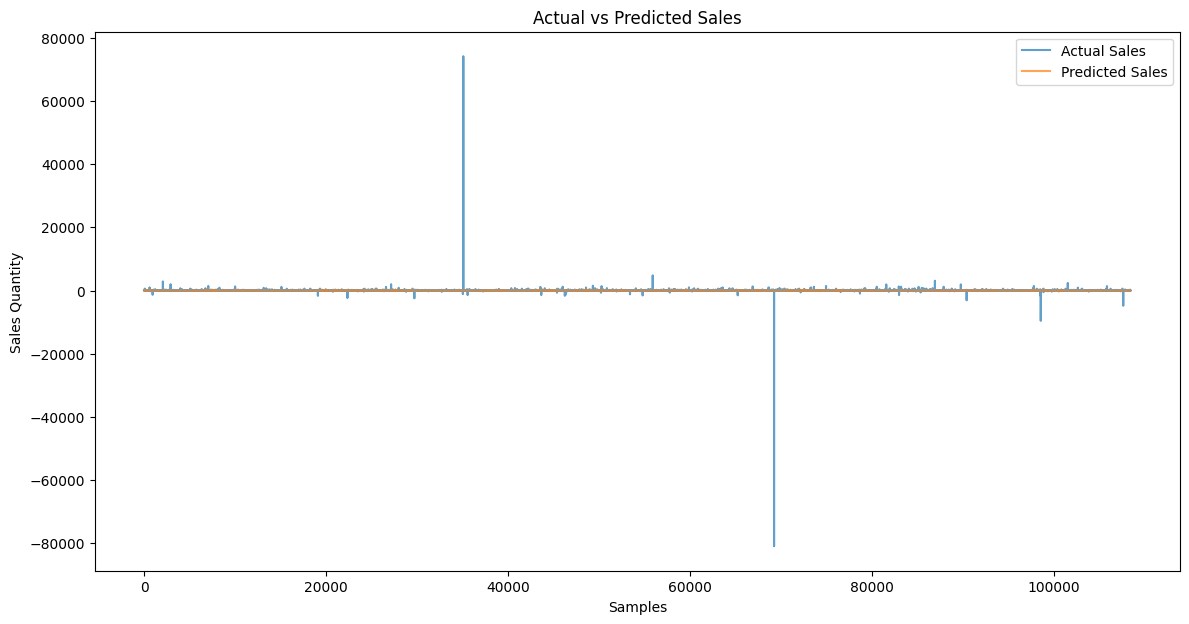

In [ ]:
# Plot actual vs predicted sales
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual Sales', alpha=0.7)
plt.plot(y_pred, label='Predicted Sales', alpha=0.7)
plt.title('Actual vs Predicted Sales')
plt.xlabel('Samples')
plt.ylabel('Sales Quantity')
plt.legend()
plt.show()

### Visualisation